<a href="https://colab.research.google.com/github/FaridRasulov/QRNN/blob/master/QRNN_TF_2x_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import os.path
import sys
import json
import numpy as np
import tensorflow as tf
from keras.datasets import imdb
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
drive.mount('/content/gdrive')
tf.test.gpu_device_name()

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


''

In [2]:
tf.__version__

'2.2.0-rc4'

**Step 1: Apply convolutions to compute intermediate vectors and gating vectors**

QRNNs use a regular convolution layer1 in the timestep dimension to compute three vectors for each input: a candidate vector, a forget gate, and an output gate. More specifically, given an input sequence of n-dimensional vectors x_1, x_2, ... x_T , the convolution layer for the candidate vectors with m filters produces a sequence of T m-dimensional output vectors z_1, z_2, ..., z_T . The same goes for the forget gates and output gates. The precise equations are

In [0]:
class DenseModel:
    
    def __init__(self, embeddings, BATCH_SIZE, SEQ_LEN, num_layers, input_size, hidden_size, conv_size, zoneout=0.1, dropout = 0.3, num_in_channels = 1):
        self.batch_size = BATCH_SIZE
        self.seq_len = SEQ_LEN
        self.embeddings = embeddings
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.conv_size = conv_size
        self.dropout = dropout
        self.zoneout = zoneout
        self.W_0 = tf.Variable(tf.random.normal([conv_size, hidden_size, num_in_channels+0, hidden_size*3]), trainable=True)
        self.W_1 = tf.Variable(tf.random.normal([conv_size, hidden_size, num_in_channels+1, hidden_size*3]), trainable=True)
        self.W_2 = tf.Variable(tf.random.normal([conv_size, hidden_size, num_in_channels+2, hidden_size*3]), trainable=True)
        self.W_3 = tf.Variable(tf.random.normal([conv_size, hidden_size, num_in_channels+3, hidden_size*3]), trainable=True)
        self.b_0 = tf.Variable(tf.random.normal([hidden_size*(3)]), trainable=True)
        self.b_1 = tf.Variable(tf.random.normal([hidden_size*(3)]), trainable=True)
        self.b_2 = tf.Variable(tf.random.normal([hidden_size*(3)]), trainable=True)
        self.b_3 = tf.Variable(tf.random.normal([hidden_size*(3)]), trainable=True)
        self.weights = [self.W_0, self.W_1, self.W_2, self.W_3]
        self.biases = [self.b_0, self.b_1, self.b_2, self.b_3]

    def __call__(self, inputs, masks, train):
        x = tf.expand_dims(tf.nn.embedding_lookup(self.embeddings, inputs), -1)
        x = self.DenseLayer(x, self.weights, self.biases, train=train)
        x = tf.transpose(tf.cast(x,dtype='float64'), perm=[1, 0, 2])
        outputs = tf.reduce_mean(x * tf.expand_dims(masks, -1), 1)
        logits = tf.keras.layers.Dense(2, dtype='float64')(tf.squeeze(outputs))
        pred = tf.argmax(tf.nn.softmax(logits), -1)        
        return pred, logits

    def DenseLayer(self, inputs, weights, biases, train):
        inputs = tf.keras.layers.Dense(self.hidden_size)(tf.transpose(inputs, [0, 1, 3, 2]))
        inputs = tf.transpose(inputs, [1, 0, 3, 2])
        for wb in zip(weights, biases):
            outputs = self.Layer(inputs, wb[0], wb[1], train=train)
            outputs = tf.nn.dropout(outputs, 1 - self.dropout) if train else outputs
            inputs = tf.concat([inputs, outputs], 3)
        return tf.squeeze(outputs[:, :, :, -1])

    def Layer(self, inputs, W, b, train):
        padded_inputs = tf.pad(inputs, [[0, 0], [self.conv_size - 1, 0], [0, 0], [0, 0]], "CONSTANT")
        conv = tf.nn.conv2d(padded_inputs, W, strides=[1, 1, 1, 1],padding='VALID') + b
        gates = tf.split(conv, 3, 3)
        F = gates[2]
        F = 1-tf.nn.dropout(F, 1-self.zoneout)if train else F
        gates[2] = F
        gates[0] = tf.tanh(gates[0])
        for i in range(1, len(gates)):
            gates[i] = tf.sigmoid(gates[i])
        Z, F, O = gates
        Z = tf.unstack(Z, axis=1)
        F = tf.unstack(F, axis=1)
        O = tf.unstack(O, axis=1)
        C = [tf.zeros(tf.shape(Z[0]), tf.float32)] # #
        H = []
        for i in range(len(Z)):
            c = tf.multiply(F[i], C[-1]) + tf.multiply(1-F[i], Z[i])
            h = tf.multiply(O[i], c)
            C.append(c)
            H.append(h)
        H = tf.stack(H, axis=1)
        return tf.transpose(H, perm=[0, 1, 3, 2])

In [0]:
NUM_EPOCHS = 1
BATCH_SIZE = 25
SEQ_LEN = 10
VOCAB_SIZE = 50
num_layers = 4
input_size = 300
num_convs = 256
conv_size = 2

trainset, valset, testset, vocab = get_datasets(BATCH_SIZE,VOCAB_SIZE,SEQ_LEN)
embeddings = get_embeddings(vocab, './gdrive/My Drive/glove.6B.300d.txt')
model = DenseModel(embeddings, BATCH_SIZE, SEQ_LEN, num_layers, input_size, num_convs, conv_size)

In [0]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []
acc_history = []

@tf.function
def train_step(model, x, masks, y):
    print('Kuku')
    inputs = np.array([i.numpy() for i in x]).T
    masks = np.array([i.numpy() for i in masks]).T
    labels = np.array([i.numpy() for i in y]).T

    with tf.GradientTape() as tape:
      print('GradKuku')
      pred, logits = model(inputs, masks, train=True)
      print('GradKuk')
      print('logits: ', logits)
      loss_value = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
      print('loss_value: ',loss_value)
      cost = tf.reduce_sum(loss_value)/BATCH_SIZE
      correct_prediction = tf.equal(tf.cast(pred, tf.int32), labels)
      acc_value = tf.reduce_sum(tf.cast(correct_prediction,tf.float32))/BATCH_SIZE


    loss_history.append(acc_value)
    acc_history.append(acc_value)
    print('GradKu')
    grads = tape.gradient(loss_value, [model.W_0, model.W_1, model.W_2, model.W_3]+[model.b_0, model.b_1, model.b_2, model.b_3])
    print('GradK')
    optimizer.apply_gradients(zip(grads, [model.W_0, model.W_1, model.W_2, model.W_3]+[model.b_0, model.b_1, model.b_2, model.b_3]))
    print('Grad')

In [22]:
for epoch in range(3):
    for x, masks, y in trainset:
      train_step(model, x, masks, y)
    print ('Epoch {} finished'.format(epoch))

Kuku
GradKuku
GradKuk
logits:  Tensor("dense_1/BiasAdd:0", shape=(25, 2), dtype=float64)
loss_value:  Tensor("SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(25,), dtype=float64)
GradKu
GradK
Grad
Kuku
GradKuku


ValueError: ignored

In [0]:
def get_embeddings(vocab, path, dim = 300):
    vocab_dict = {word: int(_id) for _id, word in vocab.items()}
    embed_id = path.split('.')[-2]
    if embed_id+'_imdb.json' not in os.listdir('.'):
        embeds = {}
        with open(path, encoding="utf8") as f:
            for line in f:
                split = line.split()
                word = split[0].encode('utf-8').lower()
                vec = split[1:]
                if word in vocab_dict.keys():
                    embeds[vocab_dict[word]] = list(map(float,vec))
        with open(embed_id+'_imdb.json', 'w') as f:
            f.write(json.dumps(embeds))
    else:
        with open(embed_id+'_imdb.json') as f:
            embeds = {int(_id): word for _id, word in json.loads(f.read()).items()}
    embed_list = []
    for i in range(3):
        initializer = tf.initializers.GlorotUniform()
        var = tf.Variable(initializer(shape=[dim]))
        embed_list.append(var)
    for _id, word in vocab.items():
        if int(_id) in embeds.keys(): embed_list.append(tf.constant(embeds[_id], dtype=tf.float32))
        else: embed_list.append(embed_list[2])
    return tf.stack(embed_list, axis=0)

class imdbDataset(Dataset):
    def __init__(self, dataset, seq_len=100):
        self.x = dataset[0]
        self.pad_inputs(seq_len)
        self.get_masks(seq_len)
        self.y = dataset[1]

    def pad_inputs(self, seq_len):
        new_xs = []
        for x in self.x:
            if len(x) > seq_len: x = x[:seq_len]
            elif len(x) < seq_len: x += [0] * (seq_len - len(x))
            assert len(x) == seq_len
            new_xs.append(x)
        self.x = new_xs

    def get_masks(self, seq_len):
        self.masks = []
        for x in self.x:
            mask = [1.0 * (x_i != 0) for x_i in x]
            assert len(mask) == seq_len
            self.masks.append(mask)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.masks[i], self.y[i]

def plot_performance(train, val, label):
    plt.plot(train)
    plt.plot(val)
    plt.ylabel(label)
    plt.xlabel('epoch')
    if label=='acc':
      plt.legend(['train', 'val'], loc='lower right')
    elif label=='loss':
      plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()

def get_datasets(batch_size=100, num_words=1000, seq_len=100):
    train, test = imdb.load_data(num_words=num_words)
    vocab = imdb.get_word_index()
    vocab = {int(_id): word.encode('utf-8').lower() for word, _id in vocab.items() if _id <= num_words}
    train = imdbDataset(train, seq_len=seq_len)
    n = int(len(test[0])/2)
    val = imdbDataset((test[0][0:n], test[1][0:n]), seq_len=seq_len)
    test = imdbDataset((test[0][n:], test[1][n:]), seq_len=seq_len)
    # if os.path.isfile('./glove.6B.300d.txt')==False:
    #         !wget http://nlp.stanford.edu/data/glove.6B.zip
    #         !unzip glove*.zip
    return (DataLoader(train, batch_size), DataLoader(val, batch_size), DataLoader(test, batch_size), vocab)

def convert_to_np(x):
    if type(x[0]) == int:
        return x.numpy()
    else:
        return np.array([x_i.numpy() for x_i in x]).T

In [0]:
tr_loss = []
tr_acc = []
vl_loss = []
vl_acc = []
with tf.Session() as sess:
    epoch = model.epoch.eval()
    for i in range(epoch, NUM_EPOCHS):
        train_loss, train_acc = run(model, sess, trainset, train=True)
        tr_acc.append(train_acc)
        tr_loss.append(train_loss)
        val_loss, val_acc = run(model, sess, valset)
        vl_acc.append(val_acc)
        vl_loss.append(val_loss)
        print('epoch: ', i, 'train loss: ', train_loss, 'train acc: ', train_acc, 'val loss: ', val_loss, 'val acc: ', val_acc)
        sess.run(tf.assign(model.epoch, i+1))
    saver.save(sess, 'checkpoints',write_state=True)

epoch:  0 train loss:  0.712325944185257 train acc:  0.5081199871301652 val loss:  0.7009464577436447 val acc:  0.5009599870443344
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'W' has type str, but expected one of: int, long, bool
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'W' has type str, but expected one of: int, long, bool


In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.get_checkpoint_state('').model_checkpoint_path)
    epoch = model.epoch.eval()
    for i in range(NUM_EPOCHS, NUM_EPOCHS):
        train_loss, train_acc = run(model, sess, trainset, train=True)
        tr_acc.append(train_acc)
        tr_loss.append(train_loss)
        val_loss, val_acc = run(model, sess, valset)
        vl_acc.append(val_acc)
        vl_loss.append(val_loss)
        print('epoch: ', i, 'train loss: ', train_loss, 'train acc: ', train_acc, 'val loss: ', val_loss, 'val acc: ', val_acc)
        sess.run(tf.assign(model.epoch, i+1))
    saver.save(sess, 'checkpoints',write_state=True)

INFO:tensorflow:Restoring parameters from checkpoints
epoch:  10 train loss:  0.5767313345074654 train acc:  0.7058800038993358 val loss:  0.5629765822291374 val acc:  0.7163200035691262
epoch:  11 train loss:  0.5697416437864303 train acc:  0.7059200035631656 val loss:  0.5559571363329887 val acc:  0.7183200053572655
epoch:  12 train loss:  0.5654054255783558 train acc:  0.7162400041520596 val loss:  0.5451382400989533 val acc:  0.7276000036001206
epoch:  13 train loss:  0.5559363066852093 train acc:  0.7223200023174285 val loss:  0.5411429395079612 val acc:  0.7292000037431717
epoch:  14 train loss:  0.5544657707214355 train acc:  0.7224400034844876 val loss:  0.5353631137609481 val acc:  0.7361600025892258
epoch:  15 train loss:  0.5498119496405125 train acc:  0.7269200032353401 val loss:  0.5405908778905869 val acc:  0.7319200034737587
epoch:  16 train loss:  0.5436905031502247 train acc:  0.7331600025594235 val loss:  0.5319896857738495 val acc:  0.741440003991127
epoch:  17 train

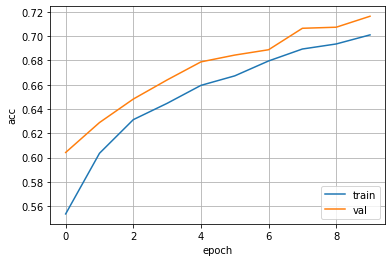

In [0]:
import matplotlib.pyplot as plt
plot_performance(tr_acc, vl_acc, 'acc')

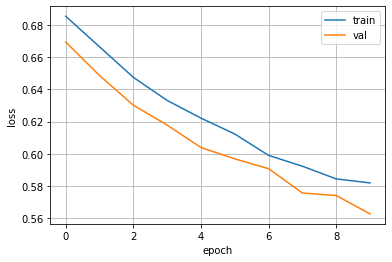

In [0]:
plot_performance(tr_loss, vl_loss, 'loss')

In [0]:
import matplotlib.pyplot as plt
plot_performance(tr_acc, vl_acc, 'acc')

NameError: ignored

In [0]:
plot_performance(tr_loss, vl_loss, 'loss')

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.get_checkpoint_state('').model_checkpoint_path)
    test_loss, test_acc = run(model, sess, testset)
    print ('test loss: ', test_loss, 'test acc: ', test_acc)

INFO:tensorflow:Restoring parameters from checkpoints
test loss:  0.55588800907135 test acc:  0.7230400323867798
